# Compare batch selection methods

## Objectives
- Until now I trained my networks using completly random samples from the training set
- Another approach is to pick baches in sequence from the dataset, until the dataset is exhausted, randomize the dataset and repeat
- In this notebook I compare the two approaches
- For a fair comparison I modified the run_training works, it is counting training examples seen by the model instead of batches

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pickle
import cv2

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.utils import shuffle

In [2]:
tf.__version__

'1.0.0'

<img align="left" src="files/old.png"> **Load data**

In [3]:
training_file = './data/train2.p'
testing_file = './data/test2.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)

<img align="left" src="files/old.png"> **Standardize naming** 

In [4]:
xtr = train['features']
ytr = train['labels']

xva, xte, yva, yte = train_test_split(test['features'], test['labels'], test_size=0.5)

<img align="left" src="files/old.png"> **One hot encoding**

In [5]:
encoder = LabelBinarizer()
encoder.fit(ytr)
ytr = encoder.transform(ytr).astype(float)
yte = encoder.transform(yte).astype(float)
yva = encoder.transform(yva).astype(float)

<img align="left" src="files/old.png"> **Normalize the input**

In [6]:
def normalize(x_in,y_in):
    
    x_out = []
    y_out = []
    for i, (image, label) in enumerate(zip(x_in, y_in)):
        zeros = np.zeros((32,32,3))
        norm_image = cv2.normalize(image, zeros, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
        x_out.append(norm_image)
        y_out.append(label)

    return x_out, y_out

In [7]:
xtr, ytr = normalize(xtr,ytr)
xte, yte = normalize(xte,yte)
xva, yva = normalize(xva,yva)

<img align="left" src="files/old.png"> **Convolutional layer**

In [8]:
def convolutional_layer(input, filter_size, in_channels, out_channels):

    filter_shape = [filter_size, filter_size, in_channels, out_channels]
    biases_shape = [out_channels]
    
    filter = tf.Variable(tf.truncated_normal(shape=filter_shape, mean=0, stddev=0.1))
    biases = tf.Variable(tf.constant(0.1, shape=biases_shape))
    
    return tf.nn.conv2d(input, filter, strides=[1, 1, 1, 1], padding='SAME') + biases

<img align="left" src="files/old.png"> **Inception module**

In [9]:
def inception_layer(layer_in, ch_in, m_ch ,ch_out):

    conv_1 = convolutional_layer(layer_in, 1, ch_in, ch_out)
    
    conv_3a = convolutional_layer(layer_in, 1, ch_in,  m_ch)
    conv_3b = convolutional_layer(conv_3a , 3, m_ch    , ch_out)
    
    conv_5a = convolutional_layer(layer_in, 1, ch_in,  m_ch)
    conv_5b = convolutional_layer(conv_5a , 5, m_ch    , ch_out)

    maxpola = tf.nn.max_pool(layer_in,[1,3,3,1],[1,1,1,1],padding='SAME')
    maxpolb = convolutional_layer(maxpola, 1, ch_in, ch_out)
    
    result = tf.concat([conv_1, conv_3b, conv_5b, maxpolb],3)
    
    result = tf.nn.relu(result)
    
    return result

<img align="left" src="files/old.png"> **Flatten the layer**

In [10]:
def flatten_layer(input):
    
    layer_shape = input.get_shape()
    num_features = layer_shape[1:4].num_elements()
    layer_flat = tf.reshape(input, [-1, num_features])
    
    return layer_flat, num_features

<img align="left" src="files/old.png"> **Fully connected layer**

In [11]:
def fully_connected_layer(input, num_features, num_outputs):
    
    weights = tf.Variable(tf.truncated_normal([num_features, num_outputs], stddev=0.05))
    biases = tf.Variable(tf.constant(0.05, shape=[num_outputs]))

    output = tf.matmul(input, weights) + biases
    
    return output

<img align="left" src="files/old.png"> **Test accuracy**

In [12]:
def test_accuracy(logits,x_data,y_data):
    
    y_pred = tf.nn.softmax(logits)
    
    y_pred_cls = tf.argmax(y_pred, dimension=1)
    y_true_cls = tf.argmax(y, dimension=1)

    prediction = tf.equal(y_pred_cls, y_true_cls)    
    
    num_examples = len(x_data)
    batch_size = 512
    all_predictions = []
    
    for offset in range(0, num_examples, batch_size):
        batch_x, batch_y = x_data[offset:offset+batch_size], y_data[offset:offset+batch_size]
        all_predictions.extend(sess.run(prediction, feed_dict = {x: batch_x, y: batch_y, keep_prob: 1})) 
    
    return np.mean(all_predictions)

## Build the computational graph using the defined functions

In [13]:
x = tf.placeholder(tf.float32, [None, 32, 32, 3])
y = tf.placeholder(tf.float32, [None, 43])

learning_rate = tf.placeholder(tf.float32)
keep_prob = tf.placeholder(tf.float32)

a = inception_layer(x, 3, 8, 16)
b = inception_layer(a, 64, 16, 32)


layer_flat, num_features = flatten_layer(b)

layer_1 = fully_connected_layer(layer_flat, num_features, 1024)
layer_1 = tf.nn.relu(layer_1)

layer_1   = tf.nn.dropout(layer_1, keep_prob)

logits = fully_connected_layer(layer_1, 1024, 43)

cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=logits,labels=y)
cost = tf.reduce_mean(cross_entropy)

grad = tf.train.GradientDescentOptimizer(learning_rate).minimize(cost)
adam = tf.train.AdamOptimizer(learning_rate).minimize(cost)

<img align="left" src="files/new.png"> **Havily modified training function**

In [14]:
def run_training(logits, optimizer, train_batch, tick, n_ticks, l_rate, keep_rate, xtr, ytr, xte, yte, tt, verbose):
    
    sess.run(tf.global_variables_initializer())
    
    result = [[],[],[],0]
    samples_seen = 0
    completed_ticks = 0
    num_examples = len(xtr)
    offset = 0
    
    while completed_ticks < n_ticks:
        
        if tt:
            
            random_state = completed_ticks*tick+samples_seen
            train_samples = train_batch
            x1, x2, y1, y2 = train_test_split(xtr, ytr, train_size=train_batch, random_state=random_state)
            
        else:
            
            end = min(offset + train_batch, num_examples)
            train_samples = end - offset
            
            x1, y1 = xtr[offset:end], ytr[offset:end]
            offset = end            
            if offset == num_examples:
                xtr, ytr = shuffle(xtr, ytr)
                offset = 0
        
        sess.run(optimizer, feed_dict = {x: x1, y: y1, learning_rate: l_rate, keep_prob: keep_rate})
        
        samples_seen = samples_seen + train_samples
        
        if  samples_seen > tick:
        
            tr_a        = test_accuracy(logits,xtr,ytr)
            te_a        = test_accuracy(logits,xte,yte)
            graph_axis  = completed_ticks * tick + samples_seen
            result[0].append(tr_a)
            result[1].append(te_a)
            result[2].append(graph_axis)
            
            samples_seen = samples_seen - tick
            completed_ticks = completed_ticks + 1
            
            if verbose:
                print graph_axis, tr_a, te_a
                
    result[3] = test_accuracy(logits,xva,yva)
    return result

In [15]:
sess = tf.Session()

In [16]:
r1, e1, s1, v1 = run_training(logits, adam, 16, 1000000, 10, 0.0001, 0.5, xtr, ytr, xte, yte, 1, 0)

In [17]:
r2, e2, s2, v2 = run_training(logits, adam, 16, 1000000, 10, 0.0001, 0.5, xtr, ytr, xte, yte, 0, 0)

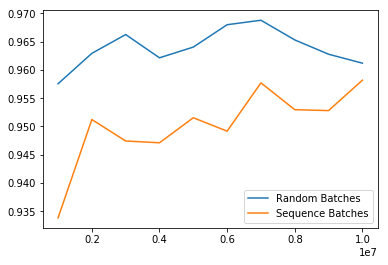

In [18]:
plt.plot(s1,e1, label='Random Batches')
plt.plot(s2,e2, label='Sequence Batches')
plt.legend()
plt.show()

In [19]:
v1, v2

(0.96199524940617576, 0.9566112430720507)